# Libraries

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier as RFC, AdaBoostClassifier as ABC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import seaborn as sn

import warnings
warnings.simplefilter("ignore")
import time

from utils import intake_data

CONFUSION_MATRICES = {}

%matplotlib inline

# Graphing Methods

In [2]:
#Confusion Matrix Function
#Create a confusion matrix
#Inputs:
#Y_Actual = Actual (true) labels
#Y_Predicted = Predicted labels from a classifier
#classifier = Name of classifier as a string for plt title
def create_cm (Y_Actual, Y_Predicted, classifier=None):
    try: 
        import seaborn as sn
    except:
        print('create_cm(Y_Actual, Y_Predicted, classifier) has a dependency on the library seaborn.')
        print('This library was not found, please install and try again.')
        return()
    if type(classifier) != str:
        print('Please input the name of the classifier for plt title as a str')
        return()

            
    data = {'Actual': Y_Actual, 'Predicted':Y_Predicted}
    df = pd.DataFrame(data, columns=['Actual', 'Predicted'])
    df['Predicted'].replace(0, 'Alive', inplace=True)
    df['Predicted'].replace(1, 'Dead', inplace=True)
    df['Actual'].replace(0, 'Alive', inplace=True)
    df['Actual'].replace(1, 'Dead', inplace=True)
    cm = pd.crosstab(df['Actual'], df['Predicted'],
                     rownames=['Actual'], colnames=['Predicted'])                                    
    #Print a formatted confusion matrix using a heatmap
    sn.heatmap(cm, annot=True)
    plt_title = 'Confusion Matrix for ' + classifier
    plt.title(plt_title)
    plt.show()

In [3]:
# report = the return value from sklearn.classification_report()
def report_plot(report, bar_width = .3):
    lines = report.split('\n')

    classes = []
    data = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        data.append(v)
    prec = [data[0][0]] + [data[1][0]]
    recall = [data[0][1]] + [data[1][1]]
    fscore = [data[0][2]] + [data[1][2]]
    
    pos1 = [a * (bar_width*4) for a in range(2)]
    pos2 = [a + bar_width for a in pos1]
    pos3 = [a + bar_width for a in pos2]
    plt.bar(pos1, prec, width = bar_width, label="precision")
    plt.bar(pos2, recall, width = bar_width, label="recall")
    plt.bar(pos3, fscore, width = bar_width, label="f-score")
    plt.xlabel("class")
    plt.xticks([a + bar_width + (a * .5 * bar_width) for a in range(2)],["survival","death"])
    plt.legend()

In [4]:
def generate_final_report(classifier_runner, graph_title=""):
    data_x, data_y = intake_data()
    pred_y = classifier_runner(data_x, data_y)
    CONFUSION_MATRICES[graph_title] = (data_y, pred_y)
    create_cm(data_y, pred_y, graph_title)
    report_plot(classification_report(data_y, pred_y))

# Naive Bayes

In [5]:
def naive_bayes_runner(data_x, data_y):
    clf = GaussianNB()
    clf.fit(data_x, data_y)
    y_predict = cross_val_predict(clf, data_x, data_y, cv = 10)
    avg_acc = accuracy_score(data_y, y_predict)
    print('Average Accuracy:', avg_acc)
    return y_predict

Using TensorFlow backend.


Average Accuracy: 0.5787401574803149


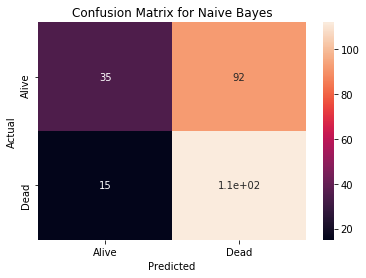

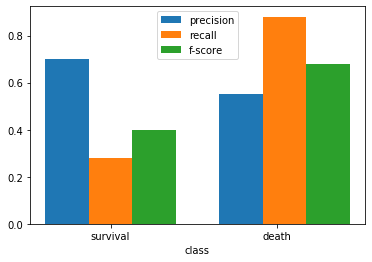

In [6]:
generate_final_report(naive_bayes_runner,"Naive Bayes")

# Decision Tree

The Decision Tree algorithm is a supervised machine learning algorithm that takes place in two steps: first, starting with the single root node, if all, or an acceptable number, of records in the node belong to a single class or all have the same attributes, the node becomes a leaf node; if the node does not become a leaf node, an attribute and test condition are chosen to split the node into child nodes. These two steps are recursively applied to create the final decision tree. It was determined that the decision tree classifier could be a suitable option for our data because it is computationally inexpensive, easy to interpret, and is resilient to noise, which our data has some of because it is such a small dataset. When running it, we looked for possible data fragmentation, or leaves with too few values, as that might be more likely to happen with such a small number of records. Further, we chose the minimum number of values in a leaf as one of the hyperparameters to watch this. 

We perform a nested cross-validation to determine the accuracy of a Decision Tree classifier on the dataset. The hyperparamters max_depth, max_features, min_samples_leaf, and criterion were chosen for this validation. The range of tested hyperparameter values was based on typical tested values, and then the ranges were reduced to accomodate the smaller number of records. If, after running the cross-validation with the chosen range of hyperparameter values, the maximum or minimum in the range was chosen, the range was extended, the cross-validation re-run, and the proecess repeated until the chosen values consistently fell on the inside of the range. 

In [7]:
def decision_tree_runner(dtree_data_X, dtree_data_Y):    
    # run a nested cross-validation 
    dt = DecisionTreeClassifier()
    params = {
        "max_depth":[1,2,3,4,5,6], 
        "max_features":[2,4,6,8,10,12,14,16], 
        "min_samples_leaf":[2,4,6,8,10,12,14,16,18,20,22,24], 
        "criterion":['gini', 'entropy']
    } 
    clf_grid_pipe = sk.model_selection.GridSearchCV(dt, param_grid = params, scoring = "accuracy", cv = 10)
    clf_grid_pipe.fit(dtree_data_X, dtree_data_Y)
    print('Best score:', round(clf_grid_pipe.best_score_, 4))
    print('Best parameters:\n',
          'max depth:', clf_grid_pipe.best_params_['max_depth'],
          '; max features:', clf_grid_pipe.best_params_['max_features'],
          '; min samples leaf:', clf_grid_pipe.best_params_['min_samples_leaf'], 
          '; criterion:', clf_grid_pipe.best_params_['criterion'])

    pred_Y = sk.model_selection.cross_val_predict(clf_grid_pipe, dtree_data_X, dtree_data_Y, cv = 10)

    print('Accuracy: '+ str(round(accuracy_score(dtree_data_Y, pred_Y), 2)*100) + '%')
    return pred_Y

Next, develop the classification report and a confusion matrix for the classifier. 

Best score: 0.7715
Best parameters:
 max depth: 6 ; max features: 16 ; min samples leaf: 2 ; criterion: gini
Accuracy: 70.0%


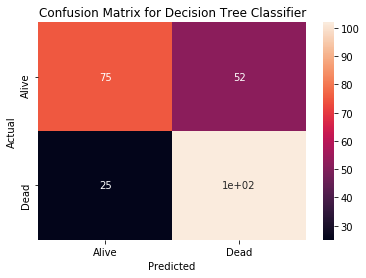

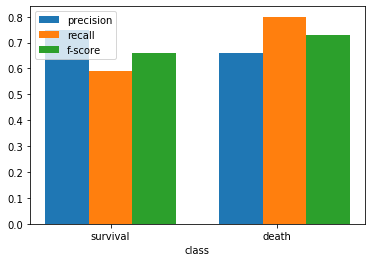

In [8]:
generate_final_report(decision_tree_runner,"Decision Tree Classifier")

## K Nearest Neighbor

###### K Nearest Neighbors
K nearest neighbors is a supervised learning algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g. distance functions) 

###### Hyperparameters

The following is straight from scikit-learn documentation:

***n_neighbors*** int, optional (default = 5)
Number of neighbors to use by default for kneighbors queries.

***weightsstr*** optional (default = ‘uniform’)
weight function used in prediction.
For uniform weights, all points in each neighborhood are weighted equally.

***metricstring***  default ‘minkowski’
The distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.

In [47]:
def knn_runner(data_x, data_y):
    knn = KNeighborsClassifier()
    feat_cols = None
    try:
        from mlxtend.feature_selection import SequentialFeatureSelector as sfs
        sfs = sfs(knn, k_features=14, forward=True, floating=False,
              verbose=2, scoring='accuracy', cv=5)
        sfs.fit(data_x, data_y)
        feat_cols = list(sfs.k_feature_idx_)
    except Exception as e:
        print(f"mlxtend required for sequential feature selection, {str(e)}")
    if feat_cols:
        data_x = data_x.iloc[:, feat_cols]
    
    scaler = StandardScaler()

    #create a new KNN classifier
    knn = KNeighborsClassifier()

    #create a pipeline that does scaling, then KNN
    pipe = Pipeline(steps=[('scaler', scaler),('knn', knn)])

    #Set up the parameters you want to tune for each of your pipeline steps
    #Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'knn__n_neighbors': list(range(1, 30)),  #find the best value of k
    }

    # pass the pipeline and the parameters into a GridSearchCV with a 5-fold cross validation
    gs = GridSearchCV(pipe, param_grid, cv=5)
    # call fit() on the GridSearchCV and pass in the unscaled data (X_values, Y_values)
    gs.fit(data_x, data_y)
    # print out the best_score_ and best_params_ from the GridSearchCV
    print("Best Score:",gs.best_score_)
    print("Chosen parameters:", gs.best_params_)

    #Printing final accuracy
    cross_val_score(gs, data_x, data_y, cv=5)
    y_predict = cross_val_predict(gs, data_x, data_y, cv=5)
    avg_acc = accuracy_score(data_y, y_predict)
    print('Average Accuracy:', avg_acc)
    return y_predict
    
    
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished

[2020-04-18 19:56:40] Features: 1/14 -- score: 0.6104313725490196[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished

[2020-04-18 19:56:40] Features: 2/14 -- score: 0.6104313725490196[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished

[2020-04-18 19:56:41] Features: 3/14 -- score: 0.6104313725490196[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Best Score: 0.736549019607843
Chosen parameters: {'knn__n_neighbors': 2}
Average Accuracy: 0.7047244094488189


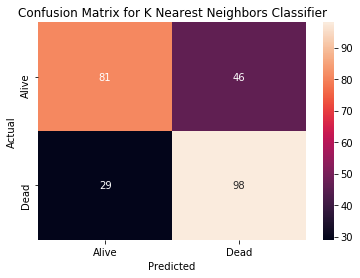

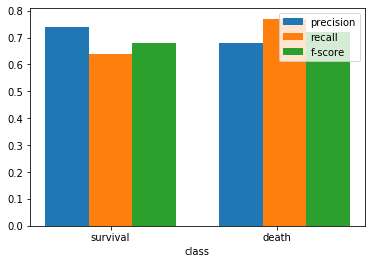

In [48]:
generate_final_report(knn_runner, "K Nearest Neighbors Classifier")

# Random Forest Classifier

Random Forests are an extension of bagged decision trees. They randomly select a subset of the input features for candidate splits to test. The feature with the best gain is selected from the subset. This process is repeated many times. The class label is then decided based on the most frequent classification from the trees. The samples are drawn with replacement.   

***Hyperparameters:***  
  
*max_depth*- The maximum depth of the tree. The range of values tested for max_depth are: [1, 10, 20, 30, 40, 50]  
  
*min_samples_leaf*- The minimum number of samples required to be a leaf node. The tree will not be split if less than min_samples_leaf is left in either the left or right branch. The range of values tested for min_samples_leafe are: [1, 2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].  
  
*max_features*- The number of features to consider when looking for the best split. Consider sqrt(n_features) and log2(n_features).  
  


In [50]:
def random_forest_runner(data_X, data_Y):
    #Create a random forest classifier
    rfc = RFC()
    #params 
    max_depth_lst = list(range(1, 51, 9))
    min_leaf_lst = list(range(1, 15))
    param_grid = {'max_depth': max_depth_lst,
                  'min_samples_leaf': min_leaf_lst,
                  'max_features': ['sqrt', 'log2']    
    }
    #grid search for best max depth, min samples per leaf and max features
    clf = GridSearchCV(rfc, param_grid, cv=5)
    #fit model to output best hyperparameters
    clf.fit(data_X, data_Y)
    print('Best values for RandomForestClassifier are:\n'+
          'max_depth:', clf.best_params_['max_depth'], '\n'+
          'min_samples_leaf:', clf.best_params_['min_samples_leaf'], '\n'+
          'max_features:', clf.best_params_['max_features'])
    #cross validation
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    avg_acc = accuracy_score(data_Y, Y_pred)
    print('Average Accuracy:', avg_acc)
    return Y_pred

Best values for RandomForestClassifier are:
max_depth: 46 
min_samples_leaf: 1 
max_features: log2
Average Accuracy: 0.6771653543307087


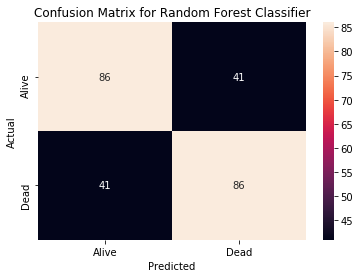

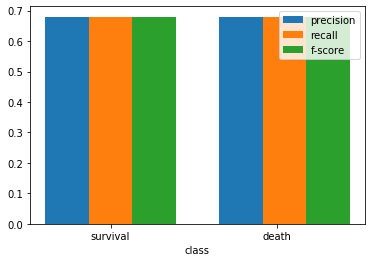

In [51]:
generate_final_report(random_forest_runner, "Random Forest Classifier")

# Neural Network

sklearn's `MLPClassifier` is a multi-layer perceptron. Input is transformed through an arbitrary number of intermediate "hidden layers" before reaching the output layer.

***Hyperparameters:***

*Hidden layer sizes:* this represents the size and shape of the hidden layers. we're testing between 1 and 8 layers with anywhere between 5 and 30 neurons per layer. These parameters provided the best balance between performance and training time.

*Activation function:* this is the activation function applied to the output of every neuron- here either logistic, tanh, or relu- all standard options.

*Solver:* this is the function used to optimize the weights in the neurons. adam is a stochastic-gradient descent based solver, and lbfgs is "an optimizer in the family of quasi-Newton methods" ([source, the MLPClassifer docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html))

*n_components:* this is the number of components that PCA will reduce the data to.

In [58]:
def neural_network_runner(x_smote, y_smote):    
    scaler = StandardScaler()
    perceptron = MLPClassifier()
    pca = PCA()

    steps = [("scaler",scaler),("pca",pca), ("nn",perceptron)]
    perceptron_pipeline = Pipeline(steps=steps)
    
    hidden_layer_sizes = []
    for layer_size in range(5,29,5):
        for layer_num in range(1,7):
            hidden_layer_sizes.append((layer_size,) * layer_num)
            
    params_grid = {
        "nn__hidden_layer_sizes":hidden_layer_sizes,
        "nn__activation":["logistic","tanh","relu"],
        "nn__solver":["lbfgs","adam"],
        'pca__n_components' :list(range(1, 20)),
    }

    grid_search = GridSearchCV(perceptron_pipeline, params_grid)
    grid_search.fit(x_smote, y_smote)
    parameter_str = f"""best parameters for neural network are\n
        hidden_layer_sizes: {grid_search.best_params_['nn__hidden_layer_sizes']}\n
        activation_function: {grid_search.best_params_['nn__activation']}\n
        solver: {grid_search.best_params_['nn__solver']}\n
        number of PCA components: {grid_search.best_params_['pca__n_components']}\n
    """
    print(parameter_str)
    y_pred = cross_val_predict(grid_search, x_smote, y_smote, cv=3)
    avg_acc = accuracy_score(y_smote, y_pred)
    print('Average Accuracy:', avg_acc)
    return y_pred

best parameters for neural network are

        hidden_layer_sizes: (15, 15, 15, 15, 15)

        activation_function: relu

        solver: lbfgs

        number of PCA components: 15

    
Average Accuracy: 0.6771653543307087


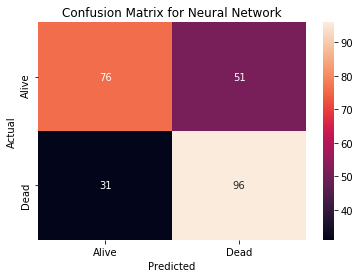

CPU times: user 1h 42min 2s, sys: 3min 40s, total: 1h 45min 43s
Wall time: 1h 43min 55s


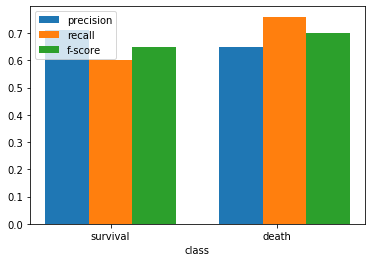

In [59]:
%%time
generate_final_report(neural_network_runner,"Neural Network")

# SVM

SVM is a classification algorithm based on seperating data using vectors in n-dimensional space.

***Hyperparameters:***

*kernel:* This controls what kernel is used to process & separate the data. We allowed the pipeline to try every option to see which is the most performant on our data.

*class_weight:* the SVM also can take in a weight matrix that determines how hard it penalizes mistakes relative to every class. we gave it five options on a spectrum between placing emphasis on each class to see which would be the most performant.

*n_components:* this is the number of components that PCA will reduce the data to.

In [52]:
def svm_runner(data_x, data_y):
    pca = PCA()
    scaler = StandardScaler()
    svc = SVC()

    steps = [("scaler", scaler), ("pca",pca), ("svc", svc)]

    pipeline = Pipeline(steps=steps)

    class_weight_options = [
        {0:.5,1:.5}, # penalizing mistakes involving the classes the same
        {0:.6,1:.4}, # slight emphasis on class 0
        {0:.4,1:.6}, # slight emphasis on class 1
        {0:.1,1:.9}, # heavy emphasis on class 1
        {0:.9,1:.1}  # heavy emphasis on class 0
    ]


    param_grid = {
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'svc__class_weight':class_weight_options,
        'pca__n_components' :list(range(1, 20)),
    }

    grid_search = GridSearchCV(pipeline, param_grid)
    grid_search.fit(data_x, data_y)
    
    parameter_str = f"""best parameters for SVM are\n
        svc__kernel: {grid_search.best_params_['svc__kernel']}\n
        svc__class_weight: {grid_search.best_params_['svc__class_weight']}\n
        number of PCA components: {grid_search.best_params_['pca__n_components']}\n
    """

    pred_y = cross_val_predict(grid_search, data_x, data_y, cv=10)
    avg_acc = accuracy_score(data_y, pred_y)
    # print('Average Accuracy:', avg_acc)
    return pred_y

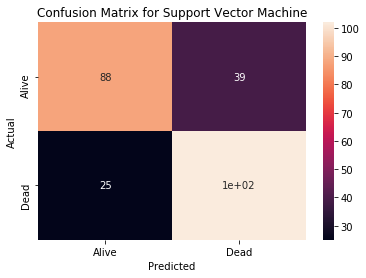

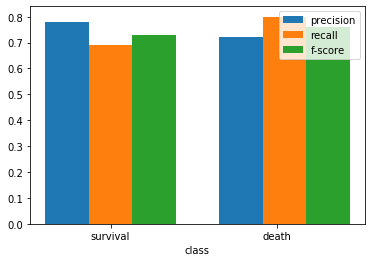

In [53]:
generate_final_report(svm_runner,"Support Vector Machine")

# AdaBoost

###### Boosting
  
AdaBoostClassifier is an ensemble classifier that iteratively changes the distribution of the training data. The base classifiers focus on hard to classify examples by assigning a weight to each example and updating that weight at the end of each boosting rund. The weight is then used as a sampling dsitribution to draw a set of bootstrap samples. The base estimator is a DecisionTreeClassifier(max_depth=1).  
  
***Hyperparameters:***  
  
*number of estimators*- The maximum number of estimators before the boosting is terminated.

In [36]:
def ada_boost_runner(data_X, data_Y):
    #create an AdaBoostClassifier
    abc = ABC()
    #params
    est_lst = list(range(5, 200, 5))
    param_grid = {'n_estimators': est_lst}
    #grid search for best n_estimators
    clf = GridSearchCV(abc, param_grid, cv=5)
    #cross validation
    Y_pred = cross_val_predict(clf, data_X, data_Y, cv=5)
    #fit model to output best hyperparameters
    clf.fit(data_X, data_Y)
    print('Best value for AdaBoostClassifier is:\n'+
          'n_estimators:', clf.best_params_['n_estimators'])
    
    avg_acc = accuracy_score(data_Y, Y_pred)
    print('Average Accuracy:', avg_acc)
    
    return Y_pred


Best value for AdaBoostClassifier is:
n_estimators: 10
Average Accuracy: 0.6771653543307087


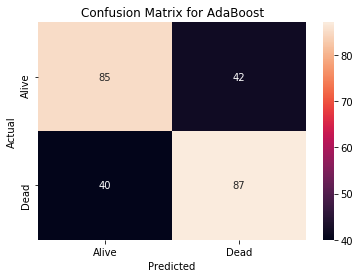

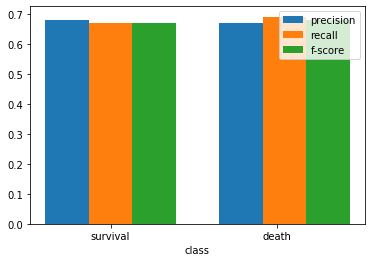

In [37]:
generate_final_report(ada_boost_runner, "AdaBoost")

# final comparison

In [55]:
# this code was modified from the matplotlib website 
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

import matplotlib.pyplot as plt
import numpy as np

def final_graph(metric):
    x_labels = CONFUSION_MATRICES.keys()
    y_label = ""
    x = np.arange(len(x_labels))
    fig, ax = plt.subplots(figsize=(15,8))
    width = 0.3
    rectlists = []
    if metric == "f1":
        values_survival = [f1_score(a[0],a[1],pos_label=0) for a in CONFUSION_MATRICES.values()]
        values_death = [f1_score(a[0],a[1],pos_label=1) for a in CONFUSION_MATRICES.values()]
        y_label = "f1 scores" 
        survival = ax.bar(x - width/2, values_survival, width, label='survival')
        death = ax.bar(x + width/2, values_death, width, label='death')
        rectlists = [survival, death]
        ax.legend()
    else:
        y_label = "accuracy"
        values = [accuracy_score(a[0],a[1]) for a in CONFUSION_MATRICES.values()]
        accuracies = ax.bar(x, values, width, label=None)
        rectlists = [accuracies]
    
    ax.set_ylabel(y_label)
    ax.set_title("Model Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

    for l in rectlists:
        autolabel(l)

    fig.tight_layout()

    plt.show()

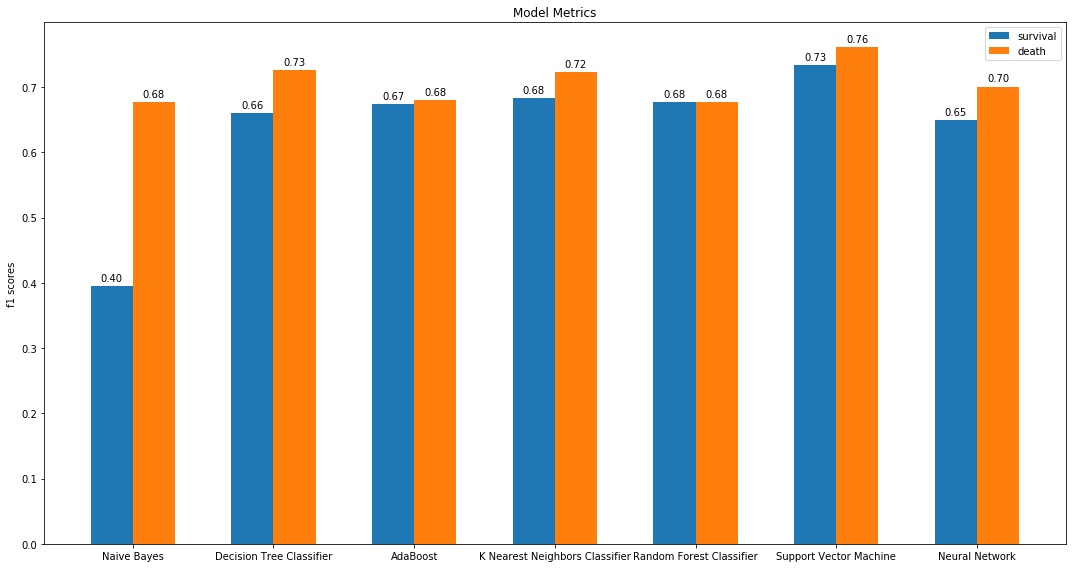

In [60]:
final_graph("f1")

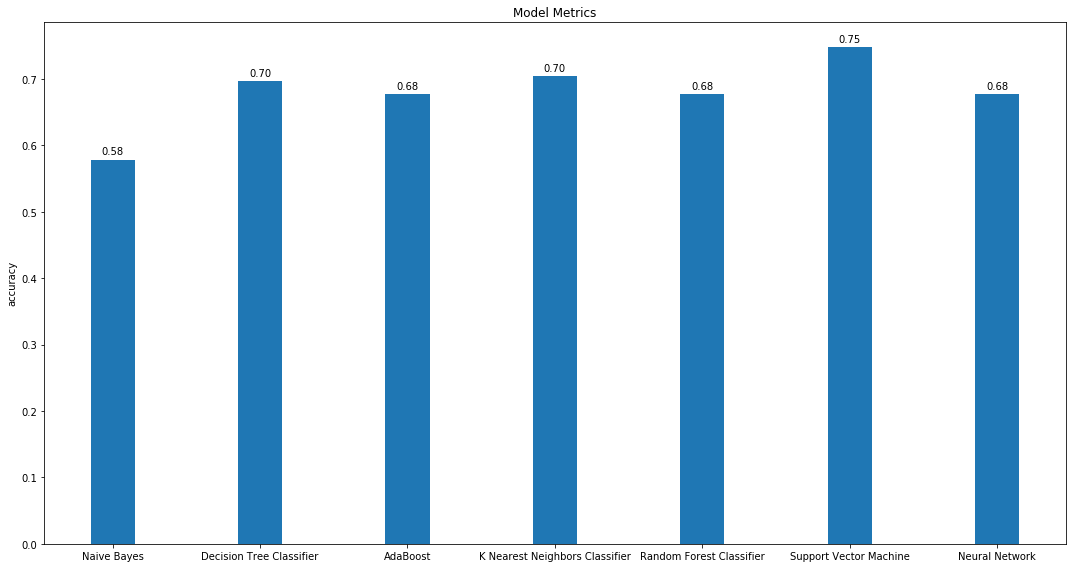

In [61]:
final_graph("accuracy")